<a href="https://www.kaggle.com/code/maxbrehmer/covid-19-detection-cnn-chest-x-ray?scriptVersionId=213849021" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# <div style="padding:18px;color:white;margin:0;font-size:35px;text-align:center;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">Covid-19 Detection - Chest X-ray</div>

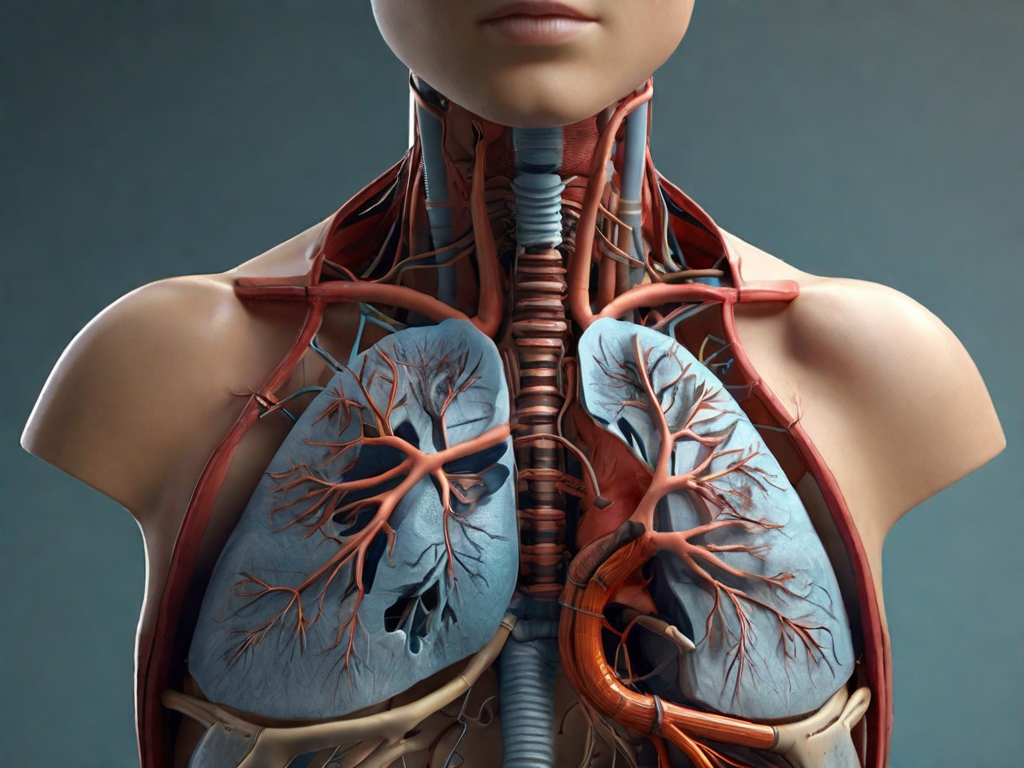


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">1 | Importing libraries | Image loading</div>

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

# Find directory paths for images
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_154.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_58.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_96.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_103.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_131.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_55.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_81.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_75.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_126.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_4.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_121.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_8.jpg
/kaggle/input/covid-19-vs-normal-chest-x-rays/NORMAL/NORMAL/normal_5.jpg
/kaggle/input/covid-19-vs-normal-che

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Assign directory path for images
train_data_dir = "/kaggle/input/covid-19-vs-normal-chest-x-rays/"
train_normal_dir = train_data_dir + "NORMAL/NORMAL/"
train_covid_dir = train_data_dir + "COVID/COVID/"

2024-12-19 11:38:18.520130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 11:38:18.520287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 11:38:18.648907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">2 | Sample Images</div>

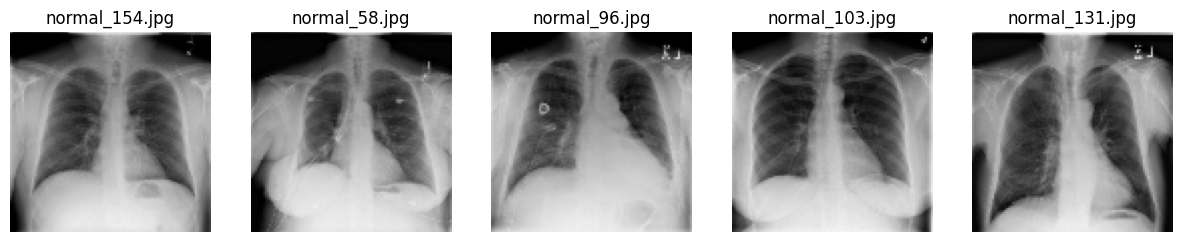

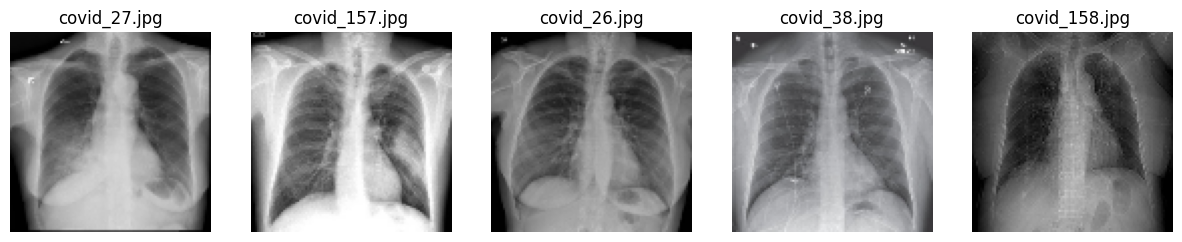

In [3]:
def display_images(directory, num_images=5, image_size=(100, 100), title=''):
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.axis('off')

    for i, image_name in enumerate(os.listdir(directory)[:num_images]):
        image_path = os.path.join(directory, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_name)

    plt.show()

display_images(train_normal_dir, title='NORMAL Images')

display_images(train_covid_dir, title='COVID Images')


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">3 | Image preprocessing</div>

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),  # Resizing on the fly
    color_mode="grayscale",              # Load as grayscale directly
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size
)

# Normalize the images to [0, 1]
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Data Augmentation Pipeline
# You can integrate these layers directly into your model, or create a separate preprocessing model.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),          # randomly flip images horizontally
    layers.RandomRotation(0.2),               # randomly rotate images by +/-20%
    layers.RandomZoom(0.2),                   # randomly zoom by 20%
])


Found 324 files belonging to 2 classes.
Using 243 files for training.
Found 324 files belonging to 2 classes.
Using 81 files for validation.



# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">4 | CNN</div>

In [5]:
# Build your model
model = models.Sequential([
    # Augmentation layers at the very beginning:
    data_augmentation, 

    # Followed by CNN layers:
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # End with Dense & output layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train directly on datasets created by image_dataset_from_directory
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


I0000 00:00:1734608317.055131      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 [==============================] - 7s 229ms/step - loss: 1.6212 - accuracy: 0.5802 - val_loss: 0.8031 - val_accuracy: 0.4691
Epoch 2/10
8/8 [==============================] - 0s 47ms/step - loss: 0.7157 - accuracy: 0.5514 - val_loss: 0.6780 - val_accuracy: 0.7160
Epoch 3/10
8/8 [==============================] - 0s 47ms/step - loss: 0.6760 - accuracy: 0.6214 - val_loss: 0.6627 - val_accuracy: 0.5679
Epoch 4/10
8/8 [==============================] - 0s 48ms/step - loss: 0.6587 - accuracy: 0.6255 - val_loss: 0.5847 - val_accuracy: 0.6790
Epoch 5/10
8/8 [==============================] - 0s 48ms/step - loss: 0.6607 - accuracy: 0.6049 - val_loss: 0.6408 - val_accuracy: 0.6296
Epoch 6/10
8/8 [==============================] - 0s 47ms/step - loss: 0.6505 - accuracy: 0.6337 - val_loss: 0.6502 - val_accuracy: 0.6173
Epoch 7/10
8/8 [==============================] - 0s 47ms/step - loss: 0.6544 - accuracy: 0.6584 - val_loss: 0.6620 - val_accuracy: 0.6173
Epoch 8/10
8/8 [=====================


# <div style="padding:18px;color:white;margin:0;font-size:25px;text-align:left;display:fill;border-radius:20px;background-color:#bc5c53;overflow:hidden">5 | Evaluation</div>

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)           

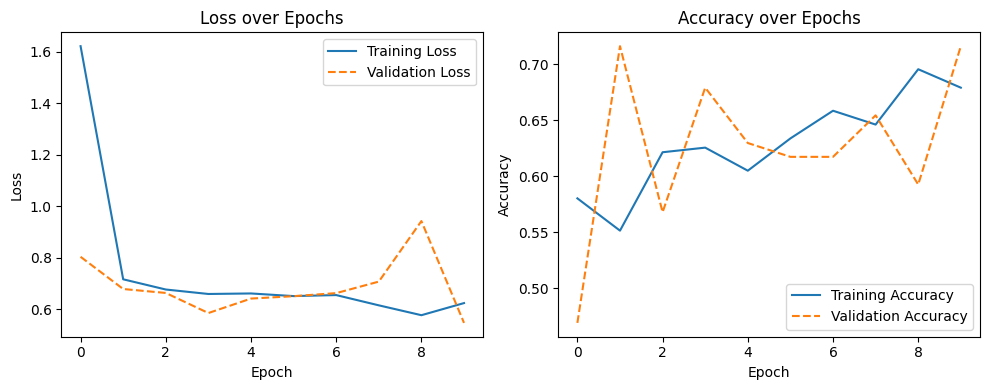

In [7]:
# Extract the loss and accuracy values for each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('acc', []))
val_acc = history.history.get('val_accuracy', history.history.get('val_acc', []))

# Plot loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()